<a href="https://colab.research.google.com/github/alarcon7a/openai-api-tutorial/blob/main/src/OpenAI_API_7_Function_Calling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Episodio 7: Function Calling - OpenAI API

In [ ]:
!pip install -qU openai

In [ ]:
from openai import OpenAI, AzureOpenAI
import os
import json
from IPython.display import display, Markdown

In [ ]:
from google.colab import userdata

api_key = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=api_key)  # Mejor usar variables de entorno

In [ ]:
# Opcional: si usas Azure OpenAI
endpoint = userdata.get("AZURE_OPENAI_ENDPOINT")
api_key = userdata.get("AZURE_OPENAI_API_KEY")
client = AzureOpenAI(
    azure_endpoint=endpoint,
    api_key=api_key,
    api_version="2024-12-01-preview",
)

## 1. Introducción a Function Calling

Function Calling es una capacidad que permite a los modelos de OpenAI llamar a funciones definidas por el usuario de manera estructurada. Esto es útil para:

- **Extraer datos estructurados** de texto no estructurado
- **Conectar el modelo con APIs externas** y servicios
- **Crear agentes** que puedan realizar acciones basadas en entradas de usuario

## 2. Definición Básica de Funciones

Lo primero que necesitamos es definir las funciones que queremos que el modelo pueda llamar.

In [ ]:
# Definir funciones usando el esquema JSON
# Esto sigue el formato JSON Schema
weather_function = {
    "type": "function",
    "function": {
        "name": "get_current_weather",
        "description": "Obtiene el clima actual en una ubicación específica",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {
                    "type": "string",
                    "description": "La ciudad y país, por ejemplo: 'Bogotá, Colombia'",
                },
                "unit": {
                    "type": "string",
                    "enum": ["celsius", "fahrenheit"],
                    "description": "La unidad de temperatura a usar",
                }
            },
            "required": ["location"],
        },
    }
}

## 3. Llamando a una Función Básica

Veamos cómo el modelo decide cuándo llamar a una función y qué parámetros utilizar.

In [ ]:
# Solicitud al modelo con function calling habilitado
response = client.chat.completions.create(
    model="gpt-4o",  # Asegúrate de usar un modelo que soporte function calling
    messages=[
        {"role": "system", "content": "Eres un asistente meteorológico útil."},
        {"role": "user", "content": "¿Cuál es el clima en Bogotá hoy?"}
    ],
    tools=[weather_function],
    tool_choice="auto"  # auto: el modelo decide si llamar a la función
)


In [ ]:
response.choices[0].message.content

In [ ]:
response.choices[0].message.tool_calls

[ChatCompletionMessageToolCall(id='call_IzPnoEOEuNYKZkURXIvxMFPF', function=Function(arguments='{"location":"Bogotá, Colombia","unit":"celsius"}', name='get_current_weather'), type='function')]

In [ ]:
response.choices[0].message

ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_IzPnoEOEuNYKZkURXIvxMFPF', function=Function(arguments='{"location":"Bogotá, Colombia","unit":"celsius"}', name='get_current_weather'), type='function')])

## 4. Implementación de la Función Real

Ahora vamos a implementar la función que será llamada cuando el modelo la invoque.

In [ ]:
import random
from datetime import datetime

def get_current_weather(location, unit="celsius"):
    """Simula obtener información del clima para una ubicación.

    En un caso real, aquí conectarías con una API de clima.
    """
    # Simulación de datos del clima
    weather_data = {
        "location": location,
        "temperature": round(random.uniform(15, 30), 1),
        "unit": unit,
        "forecast": random.choice(["soleado", "parcialmente nublado", "nublado", "lluvioso"]),
        "humidity": random.randint(30, 95),
        "wind_speed": round(random.uniform(0, 20), 1),
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }

    # Convertir a Fahrenheit si es necesario
    if unit == "fahrenheit":
        weather_data["temperature"] = round(weather_data["temperature"] * 9/5 + 32, 1)

    return weather_data

In [ ]:
get_current_weather('Bogota')

{'location': 'Bogota',
 'temperature': 26.0,
 'unit': 'celsius',
 'forecast': 'parcialmente nublado',
 'humidity': 32,
 'wind_speed': 10.0,
 'timestamp': '2025-05-28 03:29:09'}

## 5. Flujo Completo de Function Calling

Veamos el flujo completo de una conversación que implica function calling:

## Paso a Paso

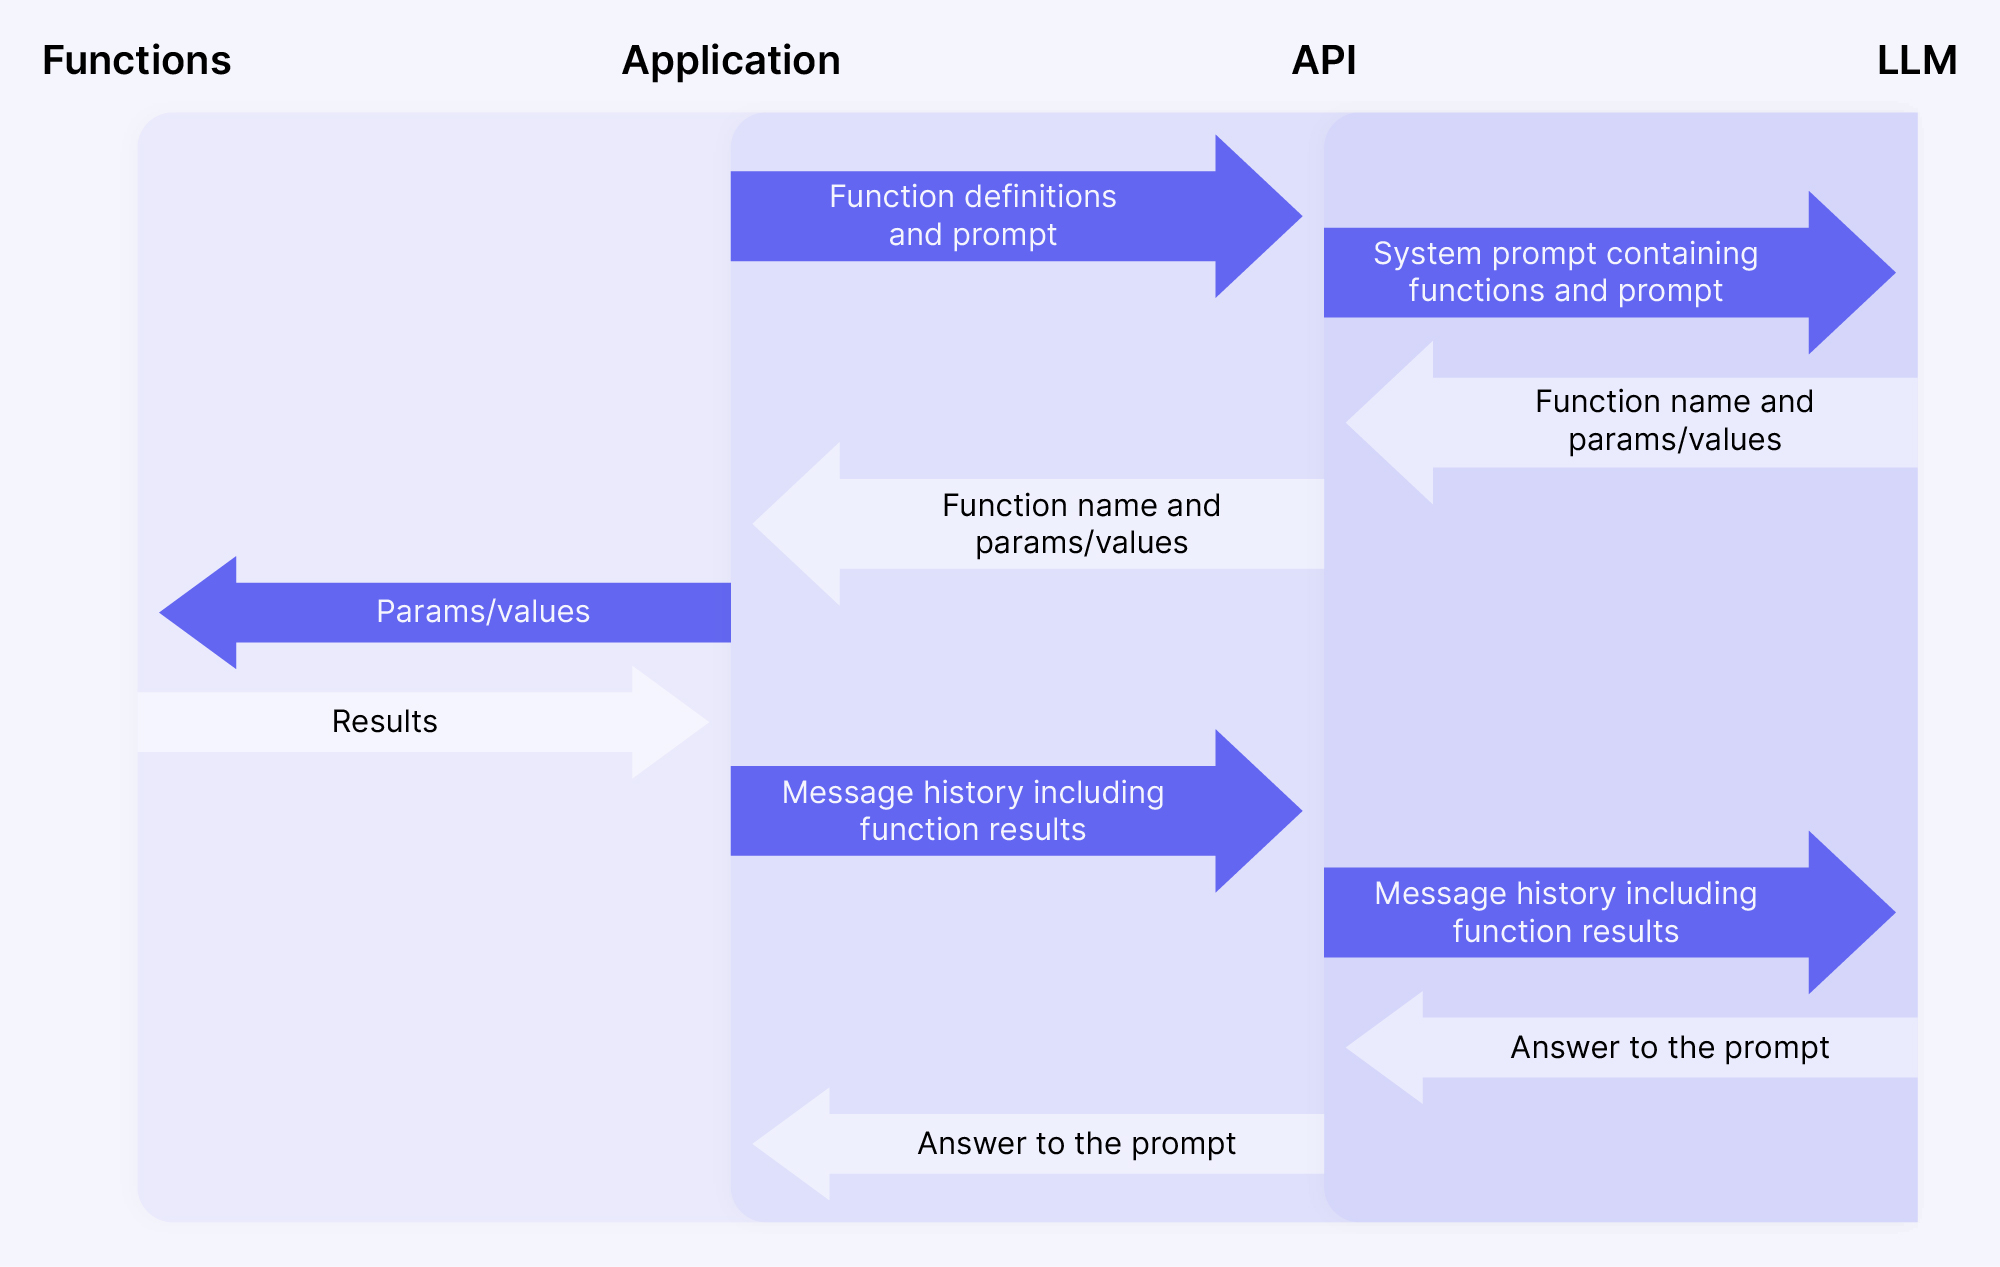

### Nuestro primer llamado con tool_call

In [ ]:
messages_test =[
    {"role": "system", "content": "Eres un asistente meteorológico útil."},
    {"role": "user", "content": "¿Qué clima hace en Bogotá?"}
]

response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages_test,
        tools=[weather_function],
        tool_choice="auto"
    )

In [ ]:
response.choices[0].message

ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_zl1IFKjzUkWJhpenAWO7oSZg', function=Function(arguments='{"location":"Bogotá, Colombia","unit":"celsius"}', name='get_current_weather'), type='function')])

### Esta respuesta de tool_call debe ser guardada en memoria

In [ ]:
messages_test.append(response.choices[0].message)
messages_test

[{'role': 'system', 'content': 'Eres un asistente meteorológico útil.'},
 {'role': 'user', 'content': '¿Qué clima hace en Bogotá?'},
 ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_zl1IFKjzUkWJhpenAWO7oSZg', function=Function(arguments='{"location":"Bogotá, Colombia","unit":"celsius"}', name='get_current_weather'), type='function')])]

### Guardando y analizando la metadata del tool calling

In [ ]:
tool_call = response.choices[0].message.tool_calls

### Nombre de la función

In [ ]:
tool_call[0].function.name

'get_current_weather'

### Parametros de la Función

In [ ]:
tool_call[0].function.arguments

'{"location":"Bogotá, Colombia","unit":"celsius"}'

In [ ]:
function_args = json.loads(tool_call[0].function.arguments)
function_args

{'location': 'Bogotá, Colombia', 'unit': 'celsius'}

### Ejecutando la función con los parametros conseguidos previamente

In [ ]:
function_response = get_current_weather(**function_args)
function_response

{'location': 'Bogotá, Colombia',
 'temperature': 26.0,
 'unit': 'celsius',
 'forecast': 'nublado',
 'humidity': 31,
 'wind_speed': 4.5,
 'timestamp': '2025-05-28 03:33:42'}

### Obteniendo el tool_call_id

In [ ]:
tool_call[0].id

'call_zl1IFKjzUkWJhpenAWO7oSZg'

### Creando la respuesta con el rol TOOL en la memoria de la conversación

In [ ]:
messages_test.append(
                {
                    "tool_call_id": tool_call[0].id,
                    "role": "tool",
                    "name": 'get_current_weather',
                    "content": json.dumps(function_response)
                }
            )

In [ ]:
messages_test

[{'role': 'system', 'content': 'Eres un asistente meteorológico útil.'},
 {'role': 'user', 'content': '¿Qué clima hace en Bogotá?'},
 ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_zl1IFKjzUkWJhpenAWO7oSZg', function=Function(arguments='{"location":"Bogotá, Colombia","unit":"celsius"}', name='get_current_weather'), type='function')]),
 {'tool_call_id': 'call_zl1IFKjzUkWJhpenAWO7oSZg',
  'role': 'tool',
  'name': 'get_current_weather',
  'content': '{"location": "Bogot\\u00e1, Colombia", "temperature": 26.0, "unit": "celsius", "forecast": "nublado", "humidity": 31, "wind_speed": 4.5, "timestamp": "2025-05-28 03:33:42"}'}]

### El segundo llamado hace la sintesis de la información con el modelo de lenguaje tomando el historico de la memoria

In [ ]:
second_response = client.chat.completions.create(
            model="gpt-4o",
            messages=messages_test,
        )

In [ ]:
second_response.choices[0].message

ChatCompletionMessage(content='En Bogotá, Colombia, actualmente hace 26 °C y el cielo está nublado. La humedad es del 31 % y hay un viento de 4.5 km/h. ¿Te gustaría más información?', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None)

## Llevemoslo a una función

In [ ]:
def process_conversation_with_function_calling(messages):
    """Procesa una conversación con function calling"""

    # Paso 1: Obtener la respuesta del modelo
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        tools=[weather_function],
        tool_choice="auto"
    )

    assistant_message = response.choices[0].message
    messages.append(assistant_message)

    # Paso 2: Comprobar si hay una llamada a función
    if assistant_message.tool_calls:
        # Paso 3: Procesar cada llamada a función
        for tool_call in assistant_message.tool_calls:
            function_name = tool_call.function.name
            function_args = json.loads(tool_call.function.arguments)

            # Mostrar información de depuración
            print(f"\n🔧 Llamada a función: {function_name}")
            print(f"📝 Argumentos: {function_args}")

            # Paso 4: Ejecutar la función correspondiente
            if function_name == "get_current_weather":
                function_response = get_current_weather(**function_args)
            else:
                function_response = {"error": f"Función {function_name} no implementada"}

            # Mostrar información de depuración
            print(f"🔄 Respuesta de la función: {function_response}")

            # Paso 5: Enviar resultado de la función al modelo
            messages.append(
                {
                    "tool_call_id": tool_call.id,
                    "role": "tool",
                    "name": function_name,
                    "content": json.dumps(function_response)
                }
            )

        # Paso 6: Obtener una nueva respuesta del modelo con los resultados de la función
        second_response = client.chat.completions.create(
            model="gpt-4o",
            messages=messages,
        )

        # Paso 7: Añadir la respuesta final a los mensajes
        final_message = second_response.choices[0].message
        messages.append(final_message)

    return messages

In [ ]:
# Iniciar una conversación
conversation = [
    {"role": "system", "content": "Eres un asistente meteorológico útil."},
    {"role": "user", "content": "¿Qué tiempo hace en Madrid?"}
]

# Procesar la conversación
conversation = process_conversation_with_function_calling(conversation)

# Mostrar la respuesta final
print("\n📱 Respuesta final:")
print(conversation[-1].content)


🔧 Llamada a función: get_current_weather
📝 Argumentos: {'location': 'Madrid, España', 'unit': 'celsius'}
🔄 Respuesta de la función: {'location': 'Madrid, España', 'temperature': 16.7, 'unit': 'celsius', 'forecast': 'nublado', 'humidity': 65, 'wind_speed': 2.6, 'timestamp': '2025-05-28 03:38:05'}

📱 Respuesta final:
Actualmente en Madrid, España, la temperatura es de 16.7 °C. Está nublado, con una humedad del 65% y una brisa ligera de 2.6 km/h.


## 6. Múltiples Funciones Disponibles

Ahora vamos a hacer disponibles múltiples funciones y ver cómo el modelo elige la correcta.

In [ ]:
# Definir funciones adicionales
calculator_function = {
    "type": "function",
    "function": {
        "name": "calculate",
        "description": "Realizar cálculos matemáticos",
        "parameters": {
            "type": "object",
            "properties": {
                "operation": {
                    "type": "string",
                    "enum": ["suma", "resta", "multiplicación", "división"],
                    "description": "Operación matemática a realizar",
                },
                "number1": {
                    "type": "number",
                    "description": "Primer número",
                },
                "number2": {
                    "type": "number",
                    "description": "Segundo número",
                }
            },
            "required": ["operation", "number1", "number2"],
        },
    }
}

calendar_function = {
    "type": "function",
    "function": {
        "name": "add_calendar_event",
        "description": "Añade un evento al calendario",
        "parameters": {
            "type": "object",
            "properties": {
                "title": {
                    "type": "string",
                    "description": "Título del evento",
                },
                "date": {
                    "type": "string",
                    "description": "Fecha del evento (YYYY-MM-DD)",
                },
                "time": {
                    "type": "string",
                    "description": "Hora del evento (HH:MM)",
                },
                "duration": {
                    "type": "integer",
                    "description": "Duración en minutos",
                },
                "description": {
                    "type": "string",
                    "description": "Descripción del evento",
                }
            },
            "required": ["title", "date", "time"],
        },
    }
}

In [ ]:
def calculate(operation, number1, number2):
    """Realiza operaciones matemáticas básicas."""
    if operation == "suma":
        result = number1 + number2
    elif operation == "resta":
        result = number1 - number2
    elif operation == "multiplicación":
        result = number1 * number2
    elif operation == "división":
        if number2 == 0:
            return {"error": "No se puede dividir por cero"}
        result = number1 / number2
    else:
        return {"error": f"Operación {operation} no reconocida"}

    return {
        "operation": operation,
        "number1": number1,
        "number2": number2,
        "result": result
    }

def add_calendar_event(title, date, time, duration=60, description=""):
    """Simula añadir un evento al calendario."""
    # En un caso real, aquí integrarías con una API de calendario
    event_id = f"evt_{random.randint(10000, 99999)}"

    return {
        "event_id": event_id,
        "title": title,
        "date": date,
        "time": time,
        "duration": duration,
        "description": description,
        "status": "created"
    }

In [ ]:
def process_conversation_with_multiple_functions(messages):
    """Procesa una conversación con múltiples funciones disponibles"""

    # Definir todas las funciones disponibles
    available_tools = [weather_function, calculator_function, calendar_function]

    # Paso 1: Obtener la respuesta del modelo
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        tools=available_tools,
        tool_choice="auto"
    )

    assistant_message = response.choices[0].message
    messages.append(assistant_message)

    # Paso 2: Comprobar si hay una llamada a función
    if assistant_message.tool_calls:
        # Paso 3: Procesar cada llamada a función
        for tool_call in assistant_message.tool_calls:
            function_name = tool_call.function.name
            function_args = json.loads(tool_call.function.arguments)

            # Mostrar información de depuración
            print(f"\n🔧 Llamada a función: {function_name}")
            print(f"📝 Argumentos: {function_args}")

            # Paso 4: Ejecutar la función correspondiente
            if function_name == "get_current_weather":
                function_response = get_current_weather(**function_args)
            elif function_name == "calculate":
                function_response = calculate(**function_args)
            elif function_name == "add_calendar_event":
                function_response = add_calendar_event(**function_args)
            else:
                function_response = {"error": f"Función {function_name} no implementada"}

            # Mostrar información de depuración
            print(f"🔄 Respuesta de la función: {function_response}")

            # Paso 5: Enviar resultado de la función al modelo
            messages.append(
                {
                    "tool_call_id": tool_call.id,
                    "role": "tool",
                    "name": function_name,
                    "content": json.dumps(function_response)
                }
            )

        # Paso 6: Obtener una nueva respuesta del modelo con los resultados de la función
        second_response = client.chat.completions.create(
            model="gpt-4o",
            messages=messages,
        )

        # Paso 7: Añadir la respuesta final a los mensajes
        final_message = second_response.choices[0].message
        messages.append(final_message)

    return messages

In [ ]:
# Probar con una pregunta de clima
climate_conversation = [
    {"role": "system", "content": "Eres un asistente útil que puede ayudar con múltiples tareas."},
    {"role": "user", "content": "¿Cómo está el clima en Berlin?"}
]

climate_conversation = process_conversation_with_multiple_functions(climate_conversation)
print("\n📱 Respuesta final:")
print(climate_conversation[-1].content)


🔧 Llamada a función: get_current_weather
📝 Argumentos: {'location': 'Berlin, Germany', 'unit': 'celsius'}
🔄 Respuesta de la función: {'location': 'Berlin, Germany', 'temperature': 27.3, 'unit': 'celsius', 'forecast': 'soleado', 'humidity': 30, 'wind_speed': 16.9, 'timestamp': '2025-05-28 03:41:05'}

📱 Respuesta final:
El clima en Berlín actualmente es soleado, con una temperatura de 27.3 °C. La humedad está en un 30 % y hay un viento moderado a una velocidad de 16.9 km/h.


In [ ]:
# Probar con una operación matemática
math_conversation = [
    {"role": "system", "content": "Eres un asistente útil que puede ayudar con múltiples tareas."},
    {"role": "user", "content": "¿Puedes calcular 145 multiplicado por 32?"}
]

math_conversation = process_conversation_with_multiple_functions(math_conversation)
print("\n📱 Respuesta final:")
print(math_conversation[-1].content)


🔧 Llamada a función: calculate
📝 Argumentos: {'operation': 'multiplicación', 'number1': 145, 'number2': 32}
🔄 Respuesta de la función: {'operation': 'multiplicación', 'number1': 145, 'number2': 32, 'result': 4640}

📱 Respuesta final:
Claro, 145 multiplicado por 32 es igual a 4640.


In [ ]:
# Probar con añadir un evento al calendario
calendar_conversation = [
    {"role": "system", "content": "Eres un asistente útil que puede ayudar con múltiples tareas."},
    {"role": "user", "content": "Por favor, agenda una reunión con Luis para el 25 de diciembre a las 10:00 para hablar sobre el proyecto."}
]

calendar_conversation = process_conversation_with_multiple_functions(calendar_conversation)
print("\n📱 Respuesta final:")
print(calendar_conversation[-1].content)


🔧 Llamada a función: add_calendar_event
📝 Argumentos: {'title': 'Reunión con Luis', 'date': '2023-12-25', 'time': '10:00', 'description': 'Hablar sobre el proyecto'}
🔄 Respuesta de la función: {'event_id': 'evt_37453', 'title': 'Reunión con Luis', 'date': '2023-12-25', 'time': '10:00', 'duration': 60, 'description': 'Hablar sobre el proyecto', 'status': 'created'}

📱 Respuesta final:
La reunión con Luis para hablar sobre el proyecto ha sido programada para el 25 de diciembre a las 10:00. ¿Te gustaría que añada algún detalle adicional?


## 7. Forzar el Uso de una Función Específica

En algunos casos, queremos asegurarnos de que el modelo utilice una función específica en lugar de dejar que decida. Esto es útil para extraer datos estructurados de manera consistente.

In [ ]:
# Definir una función para estructurar datos de contacto
contact_function = {
    "type": "function",
    "function": {
        "name": "extract_contact_info",
        "description": "Extrae información de contacto de un texto",
        "parameters": {
            "type": "object",
            "properties": {
                "name": {
                    "type": "string",
                    "description": "Nombre completo de la persona",
                },
                "email": {
                    "type": "string",
                    "description": "Dirección de correo electrónico",
                },
                "phone": {
                    "type": "string",
                    "description": "Número de teléfono",
                },
                "company": {
                    "type": "string",
                    "description": "Empresa o organización",
                },
                "position": {
                    "type": "string",
                    "description": "Cargo o posición",
                }
            },
            "required": ["name"],
        },
    }
}

In [ ]:
# Texto con información de contacto
contact_text = """Hola, soy María López, la nueva directora de marketing de Innovatech.
Pueden contactarme en maria.lopez@innovatech.com o al +34 612 345 678.
Estaré encantada de colaborar con ustedes en futuros proyectos."""

# Forzar al modelo a utilizar la función de extracción de contacto
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": contact_text}
    ],
    tools=[contact_function],
    tool_choice={"type": "function", "function": {"name": "extract_contact_info"}}  # Forzar uso de esta función
)

# Obtener los argumentos de la función
assistant_message = response.choices[0].message
function_args = json.loads(assistant_message.tool_calls[0].function.arguments)

print("Información de contacto extraída:")
print(json.dumps(function_args, indent=2, ensure_ascii=False))

Información de contacto extraída:
{
  "name": "María López",
  "email": "maria.lopez@innovatech.com",
  "phone": "+34 612 345 678",
  "company": "Innovatech",
  "position": "Directora de Marketing"
}


## 8. Caso Práctico: Asistente de Viajes con Function Calling

Ahora vamos a crear un asistente de viajes más completo combinando todas las técnicas anteriores.

In [ ]:
# Definir funciones para el asistente de viajes
travel_tools = [
    # Función 1: Búsqueda de vuelos
    {
        "type": "function",
        "function": {
            "name": "search_flights",
            "description": "Busca vuelos disponibles entre dos ciudades",
            "parameters": {
                "type": "object",
                "properties": {
                    "origin": {
                        "type": "string",
                        "description": "Ciudad de origen",
                    },
                    "destination": {
                        "type": "string",
                        "description": "Ciudad de destino",
                    },
                    "departure_date": {
                        "type": "string",
                        "description": "Fecha de salida (YYYY-MM-DD)",
                    },
                    "return_date": {
                        "type": "string",
                        "description": "Fecha de regreso (YYYY-MM-DD), opcional para vuelos de ida",
                    },
                    "num_passengers": {
                        "type": "integer",
                        "description": "Número de pasajeros",
                    }
                },
                "required": ["origin", "destination", "departure_date"],
            },
        }
    },
    # Función 2: Búsqueda de hoteles
    {
        "type": "function",
        "function": {
            "name": "search_hotels",
            "description": "Busca hoteles disponibles en una ciudad",
            "parameters": {
                "type": "object",
                "properties": {
                    "city": {
                        "type": "string",
                        "description": "Ciudad donde buscar hoteles",
                    },
                    "check_in": {
                        "type": "string",
                        "description": "Fecha de entrada (YYYY-MM-DD)",
                    },
                    "check_out": {
                        "type": "string",
                        "description": "Fecha de salida (YYYY-MM-DD)",
                    },
                    "guests": {
                        "type": "integer",
                        "description": "Número de huéspedes",
                    },
                    "max_price": {
                        "type": "number",
                        "description": "Precio máximo por noche en EUR",
                    }
                },
                "required": ["city", "check_in", "check_out"],
            },
        }
    },
    # Función 3: Información de destino
    {
        "type": "function",
        "function": {
            "name": "get_destination_info",
            "description": "Obtiene información turística sobre un destino",
            "parameters": {
                "type": "object",
                "properties": {
                    "destination": {
                        "type": "string",
                        "description": "Nombre del destino (ciudad o país)",
                    },
                    "info_type": {
                        "type": "string",
                        "enum": ["attractions", "weather", "transportation", "cuisine", "general"],
                        "description": "Tipo de información requerida",
                    }
                },
                "required": ["destination"],
            },
        }
    }
]

In [ ]:
# Implementación de las funciones del asistente de viajes
def search_flights(origin, destination, departure_date, return_date=None, num_passengers=1):
    """Simula búsqueda de vuelos."""
    # Crear datos ficticios para los vuelos
    flight_options = []
    airlines = ["AirSky", "GlobalWings", "FastJet", "OceanAir"]

    for i in range(3):  # Generar 3 opciones de vuelo
        # Generar datos aleatorios para el vuelo de ida
        departure_time = f"{random.randint(6, 22):02d}:{random.choice(['00', '15', '30', '45'])}"
        flight_duration = random.randint(2, 10)  # horas
        arrival_time = f"{(int(departure_time.split(':')[0]) + flight_duration) % 24:02d}:{departure_time.split(':')[1]}"
        price = round(random.uniform(100, 900), 2)
        airline = random.choice(airlines)
        flight_number = f"{airline[:2].upper()}{random.randint(100, 999)}"

        flight = {
            "option": i + 1,
            "outbound": {
                "airline": airline,
                "flight_number": flight_number,
                "origin": origin,
                "destination": destination,
                "date": departure_date,
                "departure_time": departure_time,
                "arrival_time": arrival_time,
                "duration_hours": flight_duration
            },
            "price_per_person": price,
            "total_price": round(price * num_passengers, 2)
        }

        # Añadir vuelo de regreso si se especifica fecha
        if return_date:
            return_departure_time = f"{random.randint(6, 22):02d}:{random.choice(['00', '15', '30', '45'])}"
            return_flight_duration = random.randint(2, 10)  # horas
            return_arrival_time = f"{(int(return_departure_time.split(':')[0]) + return_flight_duration) % 24:02d}:{return_departure_time.split(':')[1]}"
            return_airline = random.choice(airlines)
            return_flight_number = f"{return_airline[:2].upper()}{random.randint(100, 999)}"

            flight["inbound"] = {
                "airline": return_airline,
                "flight_number": return_flight_number,
                "origin": destination,
                "destination": origin,
                "date": return_date,
                "departure_time": return_departure_time,
                "arrival_time": return_arrival_time,
                "duration_hours": return_flight_duration
            }

        flight_options.append(flight)

    return {
        "search_id": f"F{random.randint(10000, 99999)}",
        "origin": origin,
        "destination": destination,
        "departure_date": departure_date,
        "return_date": return_date,
        "passengers": num_passengers,
        "num_results": len(flight_options),
        "results": flight_options
    }

def search_hotels(city, check_in, check_out, guests=1, max_price=None):
    """Simula búsqueda de hoteles."""
    # Crear datos ficticios para los hoteles
    hotel_options = []
    hotel_names = [
        "Grand Plaza Hotel", "Ocean View Resort", "City Center Inn",
        "Luxury Palace", "Comfort Suites", "Heritage Boutique Hotel"
    ]

    # Calcular número de noches
    from datetime import datetime
    check_in_date = datetime.strptime(check_in, "%Y-%m-%d")
    check_out_date = datetime.strptime(check_out, "%Y-%m-%d")
    num_nights = (check_out_date - check_in_date).days

    # Generar opciones de hotel
    for i in range(5):  # Generar 5 opciones de hotel
        hotel_name = random.choice(hotel_names)
        hotel_stars = random.randint(3, 5)
        price_per_night = round(random.uniform(50, 300), 2)

        # Si hay un precio máximo definido, ajustar
        if max_price and price_per_night > max_price:
            price_per_night = round(random.uniform(50, max_price), 2)

        hotel = {
            "option": i + 1,
            "name": f"{hotel_name}",
            "stars": hotel_stars,
            "address": f"Calle Principal {random.randint(1, 200)}, {city}",
            "price_per_night": price_per_night,
            "total_price": round(price_per_night * num_nights, 2),
            "rating": round(random.uniform(3.0, 5.0), 1),
            "amenities": random.sample(
                ["WiFi", "Piscina", "Gimnasio", "Restaurante", "Spa", "Desayuno incluido", "Parking"],
                k=random.randint(2, 5)
            )
        }

        hotel_options.append(hotel)

    # Si hay un precio máximo, filtrar los resultados
    if max_price:
        hotel_options = [h for h in hotel_options if h["price_per_night"] <= max_price]

    return {
        "search_id": f"H{random.randint(10000, 99999)}",
        "city": city,
        "check_in": check_in,
        "check_out": check_out,
        "num_nights": num_nights,
        "guests": guests,
        "num_results": len(hotel_options),
        "results": hotel_options
    }

def get_destination_info(destination, info_type="general"):
    """Simula obtener información sobre un destino turístico."""
    # Función simulada - en un caso real conectarías con una API de información turística
    # Datos ficticios para algunos destinos populares
    destinations = {
        "París": {
            "general": "París es la capital de Francia y una de las ciudades más visitadas del mundo, famosa por su gastronomía, arte y arquitectura.",
            "attractions": "Los lugares más visitados incluyen la Torre Eiffel, el Louvre, Notre Dame y los Campos Elíseos.",
            "weather": "París tiene un clima oceánico con veranos templados e inviernos fríos y lluviosos.",
            "transportation": "El metro de París es una forma eficiente de moverse por la ciudad, complementado por autobuses y el servicio de bicicletas Vélib'.",
            "cuisine": "La cocina parisina incluye platos como coq au vin, ratatouille, y una amplia variedad de quesos y vinos."
        },
        "Tokio": {
            "general": "Tokio es la capital de Japón y una de las metrópolis más grandes y modernas del mundo.",
            "attractions": "Lugares destacados incluyen el Palacio Imperial, el Templo Senso-ji, el cruce de Shibuya y la Torre de Tokio.",
            "weather": "Tokio tiene cuatro estaciones bien definidas, con veranos calurosos y húmedos e inviernos fríos y secos.",
            "transportation": "El sistema de metro y trenes de Tokio es extremadamente eficiente, aunque puede resultar complicado para los turistas.",
            "cuisine": "La gastronomía tokiota incluye sushi, ramen, tempura y una gran variedad de restaurantes especializados."
        },
        "Nueva York": {
            "general": "Nueva York es la ciudad más poblada de Estados Unidos y un centro global de finanzas, arte y cultura.",
            "attractions": "Atracciones famosas incluyen la Estatua de la Libertad, Times Square, Central Park y el Empire State Building.",
            "weather": "Nueva York experimenta las cuatro estaciones, con veranos calurosos e inviernos fríos con posibles nevadas.",
            "transportation": "El metro opera las 24 horas y es la forma más eficiente de moverse por la ciudad, junto con los icónicos taxis amarillos.",
            "cuisine": "La escena culinaria es diversa, desde hot dogs y pizza hasta restaurantes de alta cocina internacional."
        }
    }

    # Buscar el destino (caso insensitivo)
    destination_key = None
    for key in destinations.keys():
        if key.lower() == destination.lower():
            destination_key = key

    # Si no se encuentra el destino específico, proporcionar información genérica
    if not destination_key:
        return {
            "destination": destination,
            "info_type": info_type,
            "information": f"No tenemos información específica sobre {destination}. Te recomendamos consultar una guía turística actualizada o sitios web de viajes para obtener información detallada."
        }

    # Devolver la información solicitada
    return {
        "destination": destination_key,
        "info_type": info_type,
        "information": destinations[destination_key].get(info_type, destinations[destination_key]["general"])
    }

In [ ]:
def travel_assistant(messages):
    """Asistente de viajes con múltiples funciones."""

    if not messages:
        messages = [
            {"role": "system", "content": "Eres un asistente de viajes profesional. Ayuda a los usuarios a planificar sus viajes, buscar vuelos y hoteles, y proporcionar información sobre destinos turísticos."}
        ]

    # Obtener respuesta del modelo
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        tools=travel_tools,
        tool_choice="auto"
    )

    assistant_message = response.choices[0].message
    messages.append(assistant_message)

    # Procesar llamadas a funciones si las hay
    if assistant_message.tool_calls:
        for tool_call in assistant_message.tool_calls:
            function_name = tool_call.function.name
            function_args = json.loads(tool_call.function.arguments)

            # Mostrar información de depuración
            print(f"\n🔧 Llamada a función: {function_name}")
            print(f"📝 Argumentos: {function_args}")

            # Ejecutar la función correspondiente
            if function_name == "search_flights":
                function_response = search_flights(**function_args)
            elif function_name == "search_hotels":
                function_response = search_hotels(**function_args)
            elif function_name == "get_destination_info":
                function_response = get_destination_info(**function_args)
            else:
                function_response = {"error": f"Función {function_name} no implementada"}

            # Mostrar información de depuración (resumida)
            print(f"🔄 Respuesta de la función: [Datos recibidos correctamente]")

            # Enviar resultado de la función al modelo
            messages.append(
                {
                    "tool_call_id": tool_call.id,
                    "role": "tool",
                    "name": function_name,
                    "content": json.dumps(function_response)
                }
            )

        # Obtener respuesta final
        second_response = client.chat.completions.create(
            model="gpt-4o",
            messages=messages,
        )

        # Añadir respuesta final
        final_message = second_response.choices[0].message
        messages.append(final_message)

    return messages

In [ ]:
# Iniciar la conversación con el asistente de viajes
travel_conversation = [
    {"role": "system", "content": "Eres un asistente de viajes profesional. Ayuda a los usuarios a planificar sus viajes, buscar vuelos y hoteles, y proporcionar información sobre destinos turísticos."},
    {"role": "user", "content": "Estoy planeando un viaje a París. ¿Qué lugares puedo visitar allí?"}
]

# Obtener respuesta
travel_conversation = travel_assistant(travel_conversation)
print("\n📱 Respuesta del asistente:")
print(travel_conversation[-1].content)


🔧 Llamada a función: get_destination_info
📝 Argumentos: {'destination': 'París', 'info_type': 'attractions'}
🔄 Respuesta de la función: [Datos recibidos correctamente]

📱 Respuesta del asistente:
En París, puedes visitar algunos de los lugares más emblemáticos como la Torre Eiffel, el Museo del Louvre, la Catedral de Notre Dame y los Campos Elíseos. ¿Te interesa saber más detalles sobre alguno de estos sitios o necesitas ayuda para organizar las visitas?


In [ ]:
# Continuación de la conversación
travel_conversation.append(
    {"role": "user", "content": "Quiero viajar a París del 15 al 20 de diciembre. ¿Puedes buscarme vuelos desde Madrid?"}
)

# Obtener respuesta
travel_conversation = travel_assistant(travel_conversation)
print("\n📱 Respuesta del asistente:")
print(travel_conversation[-1].content)


🔧 Llamada a función: search_flights
📝 Argumentos: {'origin': 'Madrid', 'destination': 'París', 'departure_date': '2023-12-15', 'return_date': '2023-12-20'}
🔄 Respuesta de la función: [Datos recibidos correctamente]

📱 Respuesta del asistente:
He encontrado algunas opciones para tus vuelos de Madrid a París del 15 al 20 de diciembre:

1. **Opción 1:**  
   - **Ida:** AirSky, vuelo AI132  
     - Fecha: 15 de diciembre  
     - Salida: 10:30  
     - Llegada: 18:30  
     - Duración: 8 horas  
   - **Regreso:** OceanAir, vuelo OC161  
     - Fecha: 20 de diciembre  
     - Salida: 07:45  
     - Llegada: 12:45  
     - Duración: 5 horas  
   - **Precio total:** €520.38  

2. **Opción 2:**  
   - **Ida:** AirSky, vuelo AI188  
     - Fecha: 15 de diciembre  
     - Salida: 15:00  
     - Llegada: 20:00  
     - Duración: 5 horas  
   - **Regreso:** FastJet, vuelo FA957  
     - Fecha: 20 de diciembre  
     - Salida: 12:30  
     - Llegada: 17:30  
     - Duración: 5 horas  
   - **Preci

In [ ]:
# Continuación de la conversación
travel_conversation.append(
    {"role": "user", "content": "Genial. Busca también hoteles en París para esas fechas con un máximo de 200 euros por noche"}
)

# Obtener respuesta
travel_conversation = travel_assistant(travel_conversation)
print("\n📱 Respuesta del asistente:")
print(travel_conversation[-1].content)


🔧 Llamada a función: search_hotels
📝 Argumentos: {'city': 'París', 'check_in': '2023-12-15', 'check_out': '2023-12-20', 'max_price': 200}
🔄 Respuesta de la función: [Datos recibidos correctamente]

📱 Respuesta del asistente:
He encontrado varias opciones de hoteles en París dentro de tu presupuesto de 200 euros por noche del 15 al 20 de diciembre:

1. **Comfort Suites** (4 estrellas)  
   - Dirección: Calle Principal 78, París  
   - Precio por noche: €151.38  
   - Precio total: €756.90 (5 noches)  
   - Calificación: 4.2  
   - Servicios: Parking, desayuno incluido, gimnasio  

2. **Comfort Suites** (3 estrellas)  
   - Dirección: Calle Principal 85, París  
   - Precio por noche: €155.71  
   - Precio total: €778.55  
   - Calificación: 3.0  
   - Servicios: Restaurante, spa  

3. **Grand Plaza Hotel** (4 estrellas)  
   - Dirección: Calle Principal 186, París  
   - Precio por noche: €182.98  
   - Precio total: €914.90  
   - Calificación: 4.3  
   - Servicios: Restaurante, parki

In [ ]:
travel_conversation

[{'role': 'system',
  'content': 'Eres un asistente de viajes profesional. Ayuda a los usuarios a planificar sus viajes, buscar vuelos y hoteles, y proporcionar información sobre destinos turísticos.'},
 {'role': 'user',
  'content': 'Estoy planeando un viaje a París. ¿Qué lugares puedo visitar allí?'},
 ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_I1djFzwBNXUR3e7kQxr2Eo7t', function=Function(arguments='{"destination":"París","info_type":"attractions"}', name='get_destination_info'), type='function')]),
 {'tool_call_id': 'call_I1djFzwBNXUR3e7kQxr2Eo7t',
  'role': 'tool',
  'name': 'get_destination_info',
  'content': '{"destination": "Par\\u00eds", "info_type": "attractions", "information": "Los lugares m\\u00e1s visitados incluyen la Torre Eiffel, el Louvre, Notre Dame y los Campos El\\u00edseos."}'},
 ChatCompletionMessage(content='En París, puedes visitar algunos

## 9. Conclusiones

En este tutorial hemos aprendido a:

- Definir funciones que pueden ser llamadas por los modelos de OpenAI
- Permitir que el modelo decida cuándo llamar a una función
- Forzar al modelo a utilizar una función específica
- Procesar los resultados de las funciones y continuar la conversación
- Crear asistentes más potentes combinando múltiples funciones

El function calling es una herramienta poderosa para conectar los modelos de lenguaje con el mundo exterior, permitiéndoles realizar acciones concretas y proporcionando información estructurada.